In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plot


In [90]:
baslik = ['KullaniciId' , 'FilmId' , 'Degerlendirme' , 'ZamanDamgasi']
df = pd.read_csv('u.data' ,sep = '\t' , names = baslik)

In [91]:
df

,KullaniciId,FilmId,Degerlendirme,ZamanDamgasi
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


In [92]:
df.head()

,KullaniciId,FilmId,Degerlendirme,ZamanDamgasi
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [93]:
KullaniciSayisi = df.KullaniciId.unique().shape[0]
FilmSayisi = df.FilmId.unique().shape[0]
print('Kullanici sayisi = ' + str(KullaniciSayisi) ,
     'Film sayisi = ' + str(FilmSayisi))

Kullanici sayisi = 943 Film sayisi = 1682


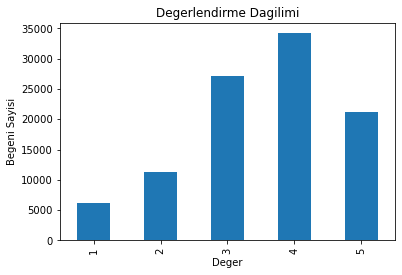

In [94]:
plot.rc("font" , size = 10)
df.Degerlendirme.value_counts(sort = False).plot(kind = 'bar')
plot.title("Degerlendirme Dagilimi")
plot.ylabel("Begeni Sayisi")
plot.xlabel("Deger")
plot.show()


In [181]:
#Filmlere göre değerlendirme ortalamaları ve değerlendirme sayılari
df_ort = pd.DataFrame(round(df.groupby("FilmId")['Degerlendirme'].mean(),2))
df_ort['DsTemp'] = pd.DataFrame(df.groupby("FilmId")['Degerlendirme'].count())
df_ort.columns =['DegerOrtalamasi' , 'DegerSayisi']
df_ort.sort_values('DegerSayisi' , ascending=False).head()


,DegerOrtalamasi,DegerSayisi
FilmId,,
50,4.36,583
258,3.80,509
100,4.16,508
181,4.01,507
294,3.16,485


In [98]:
#İşbirlikçi Filtreleme(Tavsiye Yöntemi) Kullanici-ürün matrisi
k_u_matris = np.zeros((KullaniciSayisi, FilmSayisi))
for line in df.itertuples():
    k_u_matris[line[1]-1 , line[2]-1 ] = line[3]

k_u_matris.shape


(943, 1682)


In [153]:
from sklearn.metrics.pairwise import pairwise_distances
kullanici_benzerlik = pairwise_distances(k_u_matris, metric = 'cosine')
kullanici_benzerlik.shape

(943, 943)

In [154]:
#Tahmin fonksiyonu(kullanıcı tabanlı)
def tahmin(degerlendirme ,benzerlik ):
    ortalama_degerlendirme = degerlendirme.mean(axis=1)
    
    degerlendirme_farki = (degerlendirme - ortalama_degerlendirme[: , np.newaxis])
    
    tahmin = ortalama_degerlendirme[: , np.newaxis] + benzerlik.dot(degerlendirme_farki) /  np.array([np.abs(benzerlik).sum(axis=1)]).T
            
    return(tahmin)

#Fonksiyonun çağrılması: 
#kullanici_tahmin = tahmin(k_u_matris , kullanici_benzerlik)

In [155]:
#matristeki seyreklik
seyreklik = round(1.0 - len(df) / float(KullaniciSayisi * FilmSayisi) , 4)
print('Seyreklik: %' + str(seyreklik*100))


Seyreklik: %93.7


In [156]:
#SVD matrisi
#Amaç matrisi ayrıştırmak
import scipy.sparse as sp
from scipy.sparse.linalg import svds
U, S , Vt = svds(k_u_matris, k=30)
U.shape

(943, 30)

In [157]:
#RMSE Değeri
from sklearn.metrics import mean_squared_error
from math import sqrt
def RMSE_Hesapla(tahmin , referans_veri):
    tahmin = tahmin[referans_veri.nonzero()].flatten()
    referans_veri = referans_veri[referans_veri.nonzero()].flatten()
    return sqrt(mean_squared_error(tahmin , referans_veri))

In [179]:
#Test ve egitim kümeleri
from sklearn.model_selection import train_test_split as CV
egitim_kumesi, test_kumesi = CV(df, test_size = 0.30)

#Egitim matrisi
k_u_matris_egitim = np.zeros((KullaniciSayisi , FilmSayisi))
for line in egitim_kumesi.itertuples() :
    k_u_matris_egitim[line[1]-1 , line[2]-1 ] = line[3] 
                               
#Test matrisi
k_u_matris_test = np.zeros((KullaniciSayisi , FilmSayisi))
for line in test_kumesi.itertuples() :
    k_u_matris_test[line[1]-1 , line[2]-1 ] = line[3] 
        
                           
#Benzerlik hesapları(kullanicilar)
from sklearn.metrics.pairwise import pairwise_distances
kullanici_benzerlik = pairwise_distances(k_u_matris_egitim, metric = 'cosine')

#Tahmin fonksiyonu
kullanici_tahmin = tahmin(k_u_matris_egitim , kullanici_benzerlik)        

print('Orjinal RMSE : ' + str(RMSE_Hesapla(kullanici_tahmin , k_u_matris_test))) 

#SVD
from.scipy.sparse.linalg  import svds
U, S, Vt = svds(k_u_matris_egitim , k = 30)   

S_Diyag_Matris = np.diag(S)
SVD_tahmin = np.dot(np.dot(U, S_Diyag_Matris), Vt)
                           
print('SVS RMSE : ' +  str(RMSE_Hesapla(SVD_tahmin , k_u_matris_test))) 

Orjinal RMSE : 3.159924176373157


ImportError: attempted relative import with no known parent package